In [2]:
from platform import python_version
print('Python version:',python_version())

Python version: 3.7.6


# Load Libraries

In [3]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np

from statsmodels.formula.api import logit 
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from scipy.stats import norm

import matplotlib.pyplot as plt

import seaborn as sns

## Load Dataset

In [4]:
med = pd.read_csv('/Users/jeannine/OneDrive/Documents/WGU/D208 - predictive modeling/medical_clean.csv', skipinitialspace=True, delimiter=',')
med.head()

,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,...,TotalCharge,Additional_charges,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,C412403,8cd49b13-f45a-4b47-a2bd-173ffa932c2f,3a83ddb66e2ae73798bdf1d705dc0932,Eva,AL,Morgan,35621,34.34960,-86.72508,...,3726.702860,17939.403420,3,3,2,2,4,3,3,4
1,2,Z919181,d2450b70-0337-4406-bdbb-bc1037f1734c,176354c5eef714957d486009feabf195,Marianna,FL,Jackson,32446,30.84513,-85.22907,...,4193.190458,17612.998120,3,4,3,4,4,4,3,3
2,3,F995323,a2057123-abf5-4a2c-abad-8ffe33512562,e19a0fa00aeda885b8a436757e889bc9,Sioux Falls,SD,Minnehaha,57110,43.54321,-96.63772,...,2434.234222,17505.192460,2,4,4,4,3,4,3,3
3,4,A879973,1dec528d-eb34-4079-adce-0d7a40e82205,cd17d7b6d152cb6f23957346d11c3f07,New Richland,MN,Waseca,56072,43.89744,-93.51479,...,2127.830423,12993.437350,3,5,5,3,4,5,5,5
4,5,C544523,5885f56b-d6da-43a3-8760-83583af94266,d2f0425877b10ed6bb381f3e2579424a,West Point,VA,King William,23181,37.59894,-76.88958,...,2113.073274,3716.525786,2,1,3,3,5,3,4,3


In [5]:
#trim whitespace
med = med.apply(lambda x: x.str.strip() if x.dtype == "str" else x)

## Learn shape and structure of data

In [6]:
med.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CaseOrder           10000 non-null  int64  
 1   Customer_id         10000 non-null  object 
 2   Interaction         10000 non-null  object 
 3   UID                 10000 non-null  object 
 4   City                10000 non-null  object 
 5   State               10000 non-null  object 
 6   County              10000 non-null  object 
 7   Zip                 10000 non-null  int64  
 8   Lat                 10000 non-null  float64
 9   Lng                 10000 non-null  float64
 10  Population          10000 non-null  int64  
 11  Area                10000 non-null  object 
 12  TimeZone            10000 non-null  object 
 13  Job                 10000 non-null  object 
 14  Children            10000 non-null  int64  
 15  Age                 10000 non-null  int64  
 16  Incom

In [7]:
#get number of rows and columns
med.shape

(10000, 50)

In [8]:
#Look for null values in columns

med.isnull().sum()

CaseOrder             0
Customer_id           0
Interaction           0
UID                   0
City                  0
State                 0
County                0
Zip                   0
Lat                   0
Lng                   0
Population            0
Area                  0
TimeZone              0
Job                   0
Children              0
Age                   0
Income                0
Marital               0
Gender                0
ReAdmis               0
VitD_levels           0
Doc_visits            0
Full_meals_eaten      0
vitD_supp             0
Soft_drink            0
Initial_admin         0
HighBlood             0
Stroke                0
Complication_risk     0
Overweight            0
Arthritis             0
Diabetes              0
Hyperlipidemia        0
BackPain              0
Anxiety               0
Allergic_rhinitis     0
Reflux_esophagitis    0
Asthma                0
Services              0
Initial_days          0
TotalCharge           0
Additional_charg

## Rename columns

In [9]:
#replace columns labeled item1, item2, item3, item4, item5, item6, item7, item 8 into valid names

med.rename(columns={'Item1':'timely_admission', 'Item2':'timely_treatment', 'Item3':'timely_visits', 'Item4':'reliability','Item5':'options', 'Item6':'hrsoftx', 'Item7':'courteousstaff', 'Item8':'evidenceactivelistening'}, inplace=True) 
med

,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,...,TotalCharge,Additional_charges,timely_admission,timely_treatment,timely_visits,reliability,options,hrsoftx,courteousstaff,evidenceactivelistening
0,1,C412403,8cd49b13-f45a-4b47-a2bd-173ffa932c2f,3a83ddb66e2ae73798bdf1d705dc0932,Eva,AL,Morgan,35621,34.34960,-86.72508,...,3726.702860,17939.403420,3,3,2,2,4,3,3,4
1,2,Z919181,d2450b70-0337-4406-bdbb-bc1037f1734c,176354c5eef714957d486009feabf195,Marianna,FL,Jackson,32446,30.84513,-85.22907,...,4193.190458,17612.998120,3,4,3,4,4,4,3,3
2,3,F995323,a2057123-abf5-4a2c-abad-8ffe33512562,e19a0fa00aeda885b8a436757e889bc9,Sioux Falls,SD,Minnehaha,57110,43.54321,-96.63772,...,2434.234222,17505.192460,2,4,4,4,3,4,3,3
3,4,A879973,1dec528d-eb34-4079-adce-0d7a40e82205,cd17d7b6d152cb6f23957346d11c3f07,New Richland,MN,Waseca,56072,43.89744,-93.51479,...,2127.830423,12993.437350,3,5,5,3,4,5,5,5
4,5,C544523,5885f56b-d6da-43a3-8760-83583af94266,d2f0425877b10ed6bb381f3e2579424a,West Point,VA,King William,23181,37.59894,-76.88958,...,2113.073274,3716.525786,2,1,3,3,5,3,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,B863060,a25b594d-0328-486f-a9b9-0567eb0f9723,39184dc28cc038871912ccc4500049e5,Norlina,NC,Warren,27563,36.42886,-78.23716,...,6850.942000,8927.642000,3,2,2,3,4,3,4,2
9996,9997,P712040,70711574-f7b1-4a17-b15f-48c54564b70f,3cd124ccd43147404292e883bf9ec55c,Milmay,NJ,Atlantic,8340,39.43609,-74.87302,...,7741.690000,28507.150000,3,3,4,2,5,3,4,4
9997,9998,R778890,1d79569d-8e0f-4180-a207-d67ee4527d26,41b770aeee97a5b9e7f69c906a8119d7,Southside,TN,Montgomery,37171,36.36655,-87.29988,...,8276.481000,15281.210000,3,3,3,4,4,2,3,2
9998,9999,E344109,f5a68e69-2a60-409b-a92f-ac0847b27db0,2bb491ef5b1beb1fed758cc6885c167a,Quinn,SD,Pennington,57775,44.10354,-102.01590,...,7644.483000,7781.678000,5,5,3,4,4,3,4,3


## Transform categorical data to assigned numerical values

In [13]:
#put complication risk column as ordinal for low, medium, high before tranforming to numeric value 
complication_risk_order = CategoricalDtype(['Low', 'Medium', 'High'], ordered=True)
complication_risk_order

#assign order to column
med['Complication_risk'] = med['Complication_risk'].astype(complication_risk_order)
med['Complication_risk']

0       Medium
1         High
2       Medium
3       Medium
4          Low
         ...  
9995    Medium
9996    Medium
9997      High
9998    Medium
9999       Low
Name: Complication_risk, Length: 10000, dtype: category
Categories (3, object): [Low < Medium < High]

In [14]:
#put marital column as ordinal for never married, married, widowed, separated, divorced before transforming to numeric value

marital_order = CategoricalDtype(['Never Married', 'Married', 'Widowed','Separated', 'Divorced'], ordered=True)
marital_order

med['Marital'] = med['Marital'].astype(marital_order)
med['Marital'].unique()

[Divorced, Married, Widowed, Never Married, Separated]
Categories (5, object): [Never Married < Married < Widowed < Separated < Divorced]

In [15]:
#create a different column or transform existing column to a category
med['city_cat'] = med['City'].astype('category')
med['state_cat'] = med['State'].astype('category')
med['area_cat'] = med['Area'].astype('category')
med['job_cat'] = med['Job'].astype('category')
med['marital_cat'] = med['Marital'].astype(marital_order)
med['gender_cat'] = med['Gender'].astype('category')
med['readmis_cat'] = med['ReAdmis'].astype('category')
med['initialadmin_cat'] = med['Initial_admin'].astype('category')
med['highblood_cat'] = med['HighBlood'].astype('category')
med['stroke_cat'] = med['Stroke'].astype('category')
med['complicationrisk_cat'] = med['Complication_risk'].astype(complication_risk_order)
med['overweight_cat'] = med['Overweight'].astype('category')
med['arthritis_cat'] = med['Arthritis'].astype('category')
med['diabetes_cat'] = med['Diabetes'].astype('category')
med['hyperlipidemia_cat'] = med['Hyperlipidemia'].astype('category')
med['backpain_cat'] = med['BackPain'].astype('category')
med['anxiety_cat'] = med['Anxiety'].astype('category')
med['allergicrhinitis_cat'] = med['Allergic_rhinitis'].astype('category')
med['refluxesophagitis_cat'] = med['Reflux_esophagitis'].astype('category')
med['asthma_cat'] = med['Asthma'].astype('category')
med['services_cat'] = med['Services'].astype('category')
print(med.dtypes)

CaseOrder                   int64
Customer_id                object
Interaction                object
UID                        object
City                       object
                           ...   
anxiety_cat              category
allergicrhinitis_cat     category
refluxesophagitis_cat    category
asthma_cat               category
services_cat             category
Length: 71, dtype: object


In [16]:
#pull unique values and test if ordinal position exists
med['complicationrisk_cat'].unique()

[Medium, High, Low]
Categories (3, object): [Low < Medium < High]

In [17]:
#change categorical columns to numeric values 

med['city_cat'] = med['city_cat'].cat.codes
med['state_cat'] = med['state_cat'].cat.codes
med['area_cat'] = med['area_cat'].cat.codes
med['job_cat'] = med['job_cat'].cat.codes
med['marital_cat'] = med['marital_cat'].cat.codes
med['gender_cat'] = med['gender_cat'].cat.codes
med['readmis_cat'] = med['readmis_cat'].cat.codes
med['initialadmin_cat'] = med['initialadmin_cat'].cat.codes
med['highblood_cat'] = med['highblood_cat'].cat.codes
med['stroke_cat'] = med['stroke_cat'].cat.codes
med['complicationrisk_cat'] = med['complicationrisk_cat'].cat.codes
med['overweight_cat'] = med['overweight_cat'].cat.codes
med['arthritis_cat'] = med['arthritis_cat'].cat.codes
med['diabetes_cat'] = med['diabetes_cat'].cat.codes
med['hyperlipidemia_cat'] = med['hyperlipidemia_cat'].cat.codes
med['backpain_cat'] = med['backpain_cat'].cat.codes
med['anxiety_cat'] = med['anxiety_cat'].cat.codes
med['allergicrhinitis_cat'] = med['allergicrhinitis_cat'].cat.codes
med['refluxesophagitis_cat'] = med['refluxesophagitis_cat'].cat.codes
med['asthma_cat'] = med['asthma_cat'].cat.codes
med['services_cat'] = med['services_cat'].cat.codes
print(med.dtypes)

CaseOrder                 int64
Customer_id              object
Interaction              object
UID                      object
City                     object
                          ...  
anxiety_cat                int8
allergicrhinitis_cat       int8
refluxesophagitis_cat      int8
asthma_cat                 int8
services_cat               int8
Length: 71, dtype: object


In [18]:
#drop columns that were transformed into numeric values 
med1 = med.drop(columns=['City','State','Area','Job','Marital','Gender','ReAdmis','Initial_admin','HighBlood','Stroke',
                         'Complication_risk', 'Overweight','Arthritis','Diabetes','Hyperlipidemia','BackPain','Anxiety',
                         'Allergic_rhinitis','Reflux_esophagitis','Asthma','Services'])
med1.head()



,CaseOrder,Customer_id,Interaction,UID,County,Zip,Lat,Lng,Population,TimeZone,...,overweight_cat,arthritis_cat,diabetes_cat,hyperlipidemia_cat,backpain_cat,anxiety_cat,allergicrhinitis_cat,refluxesophagitis_cat,asthma_cat,services_cat
0,1,C412403,8cd49b13-f45a-4b47-a2bd-173ffa932c2f,3a83ddb66e2ae73798bdf1d705dc0932,Morgan,35621,34.34960,-86.72508,2951,America/Chicago,...,0,1,1,0,1,1,1,0,1,0
1,2,Z919181,d2450b70-0337-4406-bdbb-bc1037f1734c,176354c5eef714957d486009feabf195,Jackson,32446,30.84513,-85.22907,11303,America/Chicago,...,1,0,0,0,0,0,0,1,0,2
2,3,F995323,a2057123-abf5-4a2c-abad-8ffe33512562,e19a0fa00aeda885b8a436757e889bc9,Minnehaha,57110,43.54321,-96.63772,17125,America/Chicago,...,1,0,1,0,0,0,0,0,0,0
3,4,A879973,1dec528d-eb34-4079-adce-0d7a40e82205,cd17d7b6d152cb6f23957346d11c3f07,Waseca,56072,43.89744,-93.51479,2162,America/Chicago,...,0,1,0,0,0,0,0,1,1,0
4,5,C544523,5885f56b-d6da-43a3-8760-83583af94266,d2f0425877b10ed6bb381f3e2579424a,King William,23181,37.59894,-76.88958,5287,America/New_York,...,0,0,0,1,0,0,1,0,0,1


## Explore Data

In [19]:
med1.describe()

,CaseOrder,Zip,Lat,Lng,Population,Children,Age,Income,VitD_levels,Doc_visits,...,overweight_cat,arthritis_cat,diabetes_cat,hyperlipidemia_cat,backpain_cat,anxiety_cat,allergicrhinitis_cat,refluxesophagitis_cat,asthma_cat,services_cat
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,5000.50000,50159.323900,38.751099,-91.243080,9965.253800,2.097200,53.511700,40490.495160,17.964262,5.012200,...,0.709400,0.357400,0.27380,0.337200,0.411400,0.321500,0.394100,0.413500,0.28930,0.862500
std,2886.89568,27469.588208,5.403085,15.205998,14824.758614,2.163659,20.638538,28521.153293,2.017231,1.045734,...,0.454062,0.479258,0.44593,0.472777,0.492112,0.467076,0.488681,0.492486,0.45346,0.986251
min,1.00000,610.000000,17.967190,-174.209700,0.000000,0.000000,18.000000,154.080000,9.806483,1.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,2500.75000,27592.000000,35.255120,-97.352982,694.750000,0.000000,36.000000,19598.775000,16.626439,4.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,5000.50000,50207.000000,39.419355,-88.397230,2769.000000,1.000000,53.000000,33768.420000,17.951122,5.000000,...,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,7500.25000,72411.750000,42.044175,-80.438050,13945.000000,3.000000,71.000000,54296.402500,19.347963,6.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,2.000000
max,10000.00000,99929.000000,70.560990,-65.290170,122814.000000,10.000000,89.000000,207249.100000,26.394449,9.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,3.000000


# Go through each variable to identify the summary statistics individually

In [25]:
# create predictor and response variables to use in calculations

predictor_var = med1['Initial_days']

response_var = med['ReAdmis']

predictor_mean = predictor_var.mean()

var_range = (predictor_var.max()-predictor_var.min())

In [26]:
predictor_var.describe()

count    10000.000000
mean        34.455299
std         26.309341
min          1.001981
25%          7.896215
50%         35.836244
75%         61.161020
max         71.981490
Name: Initial_days, dtype: float64

In [27]:
# find middle point between range of values

var_range = (predictor_var.max()-predictor_var.min())
print(var_range)
print(var_range/2)

70.979509081
35.4897545405


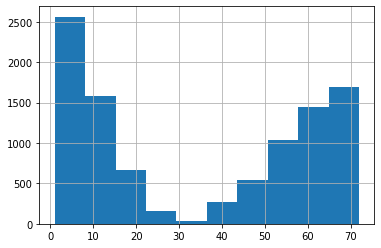

In [28]:
predictor_var.hist()

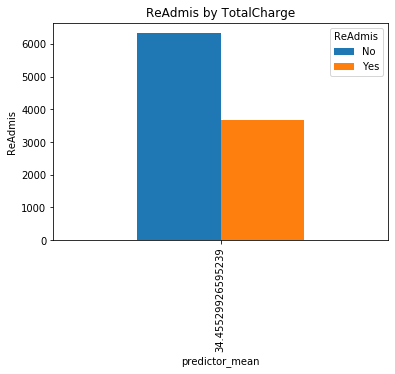

In [29]:
# distribution of mean between predictor variable and target variable

pd.crosstab(predictor_mean, response_var).plot(kind='bar')
plt.title('ReAdmis by TotalCharge')
plt.xlabel('predictor_mean')
plt.ylabel('ReAdmis')
plt.savefig('Readmission by predictor_mean')

In [30]:
predictor_var.value_counts()

63.544320    2
70.325420    2
67.421390    2
41.248710    1
7.501392     1
            ..
3.258476     1
22.269437    1
52.205010    1
2.376244     1
10.938571    1
Name: Initial_days, Length: 9997, dtype: int64

In [31]:
med['readmis_cat'].value_counts()

0    6331
1    3669
Name: readmis_cat, dtype: int64

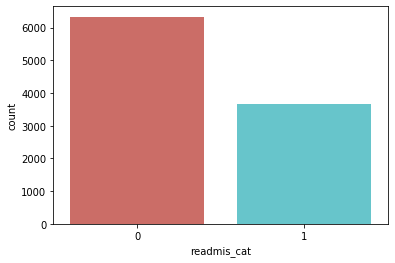

<Figure size 432x288 with 0 Axes>

In [32]:
sns.countplot(x='readmis_cat', data=med, palette='hls')
plt.show()
plt.savefig('count_plot')

In [33]:
# get percentage of readmissions and no readmissions in the populations

count_no_readmis = len(med[med['readmis_cat']==0])
count_readmis = len(med[med['readmis_cat']==1])
pct_of_no_readmis = count_no_readmis/(count_no_readmis+count_readmis)
print('percentage of no readmis is', pct_of_no_readmis*100)
pct_of_readmis = count_readmis/(count_no_readmis+count_readmis)
print('percentage of readmis is', pct_of_readmis*100)

percentage of no readmis is 63.31
percentage of readmis is 36.69


In [34]:
# Get averages

pd.set_option('display.max_columns',None)
med.groupby('readmis_cat').mean()

,CaseOrder,Zip,Lat,Lng,Population,Children,Age,Income,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Initial_days,TotalCharge,Additional_charges,timely_admission,timely_treatment,timely_visits,reliability,options,hrsoftx,courteousstaff,evidenceactivelistening,city_cat,state_cat,area_cat,job_cat,marital_cat,gender_cat,initialadmin_cat,highblood_cat,stroke_cat,complicationrisk_cat,overweight_cat,arthritis_cat,diabetes_cat,hyperlipidemia_cat,backpain_cat,anxiety_cat,allergicrhinitis_cat,refluxesophagitis_cat,asthma_cat,services_cat
readmis_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3550.541779,49987.470700,38.810183,-91.228998,9739.104249,2.058443,53.263308,40740.257109,17.957993,5.012004,1.010741,0.393619,17.414699,3911.772150,12866.696031,3.531985,3.508608,3.520297,3.516664,3.492497,3.535776,3.497868,3.522982,3015.984047,25.771126,0.988154,318.989733,2.011215,0.514453,0.993524,0.408150,0.199021,1.125099,0.712368,0.354604,0.274838,0.335650,0.406413,0.320644,0.395830,0.411467,0.295214,0.866688
1,7502.458436,50455.863178,38.649146,-91.267379,10355.483510,2.164077,53.940311,40059.521352,17.975079,5.012537,0.985282,0.408013,63.859507,7728.617663,13051.576261,3.496048,3.503407,3.495230,3.512401,3.504497,3.499591,3.487326,3.486781,3015.535568,25.773780,1.002453,321.157809,1.958299,0.528482,0.992641,0.410466,0.199782,1.120196,0.704279,0.362224,0.272009,0.339875,0.420005,0.322976,0.391115,0.417007,0.279095,0.855274


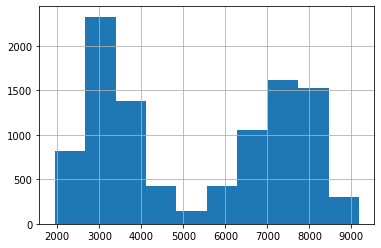

In [35]:
med['TotalCharge'].hist()

In [36]:
# Get averages

pd.set_option('display.max_columns',None)
med.groupby(med['TotalCharge']>5300).mean()

,CaseOrder,Zip,Lat,Lng,Population,Children,Age,Income,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Initial_days,TotalCharge,Additional_charges,timely_admission,timely_treatment,timely_visits,reliability,options,hrsoftx,courteousstaff,evidenceactivelistening,city_cat,state_cat,area_cat,job_cat,marital_cat,gender_cat,readmis_cat,initialadmin_cat,highblood_cat,stroke_cat,complicationrisk_cat,overweight_cat,arthritis_cat,diabetes_cat,hyperlipidemia_cat,backpain_cat,anxiety_cat,allergicrhinitis_cat,refluxesophagitis_cat,asthma_cat,services_cat
TotalCharge,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,2528.464542,49788.109960,38.759562,-91.064545,9748.342032,2.049402,53.225498,40702.650436,17.980139,5.023506,1.018725,0.388446,9.359330,3254.853018,12887.642732,3.543426,3.517331,3.522709,3.526295,3.494223,3.533068,3.488645,3.516335,3023.217928,25.801195,0.981873,319.022709,2.014940,0.512948,0.000000,0.996016,0.409363,0.198207,1.128486,0.716335,0.348207,0.273506,0.340040,0.402191,0.315936,0.390438,0.407769,0.297610,0.866335
True,7492.391165,50533.519478,38.742568,-91.423049,10183.907831,2.145382,53.800201,40276.635825,17.948257,5.000803,0.983936,0.409438,59.752843,7386.017176,12981.791036,3.493976,3.495984,3.499398,3.503815,3.499598,3.511847,3.499398,3.503012,3008.361647,25.742771,1.005020,320.553815,1.968474,0.526305,0.736747,0.990361,0.408635,0.200402,1.118072,0.702410,0.366667,0.274096,0.334337,0.420683,0.327108,0.397791,0.419277,0.280924,0.858635


In [37]:
# Get averages

pd.set_option('display.max_columns',None)
med.groupby('TotalCharge').mean()

,CaseOrder,Zip,Lat,Lng,Population,Children,Age,Income,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Initial_days,Additional_charges,timely_admission,timely_treatment,timely_visits,reliability,options,hrsoftx,courteousstaff,evidenceactivelistening,city_cat,state_cat,area_cat,job_cat,marital_cat,gender_cat,readmis_cat,initialadmin_cat,highblood_cat,stroke_cat,complicationrisk_cat,overweight_cat,arthritis_cat,diabetes_cat,hyperlipidemia_cat,backpain_cat,anxiety_cat,allergicrhinitis_cat,refluxesophagitis_cat,asthma_cat,services_cat
TotalCharge,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1938.312067,2509.0,36910.0,32.20460,-88.14694,21.0,1.0,55.0,28997.61,15.724402,5.0,1.0,0.0,1.008401,9104.545363,6.0,5.0,5.0,3.0,2.0,5.0,4.0,5.0,2590.0,1.0,1.0,282.0,4.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1957.445547,3655.0,49866.0,46.52136,-87.57874,8092.0,1.0,70.0,9856.13,17.224741,6.0,1.0,0.0,1.241913,11563.297100,4.0,4.0,4.0,4.0,5.0,4.0,5.0,3.0,3713.0,22.0,0.0,481.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1969.472468,2496.0,89422.0,38.17367,-118.41485,111.0,0.0,84.0,107038.60,18.740713,7.0,2.0,2.0,1.388694,13774.090550,4.0,3.0,3.0,4.0,2.0,3.0,4.0,5.0,3489.0,33.0,1.0,330.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000.776336,4213.0,70820.0,30.36901,-91.18539,19507.0,3.0,30.0,51249.78,18.617403,5.0,0.0,1.0,1.042379,5198.343809,6.0,4.0,6.0,3.0,2.0,4.0,4.0,4.0,291.0,18.0,0.0,268.0,3.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2004.755279,3086.0,59724.0,44.70971,-112.74681,67.0,1.0,87.0,20057.09,18.626597,6.0,3.0,2.0,1.079944,14286.618530,5.0,4.0,5.0,3.0,5.0,3.0,3.0,3.0,1315.0,26.0,0.0,286.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9067.605000,5462.0,25022.0,37.85869,-81.81170,364.0,0.0,85.0,49190.31,17.744190,5.0,1.0,0.0,71.268050,15465.960000,4.0,4.0,3.0,4.0,3.0,5.0,3.0,5.0,454.0,50.0,1.0,384.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
9077.388000,9404.0,50607.0,42.61067,-91.74982,510.0,0.0,65.0,20671.21,17.957470,5.0,1.0,1.0,70.583100,22158.540000,4.0,5.0,4.0,4.0,3.0,4.0,3.0,4.0,218.0,12.0,2.0,515.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
9080.912000,5501.0,23518.0,36.91647,-76.21588,29723.0,5.0,67.0,14005.56,22.236420,6.0,4.0,0.0,70.798970,22873.980000,4.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3854.0,46.0,0.0,367.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0


In [38]:
med.groupby('stroke_cat').mean()

,CaseOrder,Zip,Lat,Lng,Population,Children,Age,Income,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Initial_days,TotalCharge,Additional_charges,timely_admission,timely_treatment,timely_visits,reliability,options,hrsoftx,courteousstaff,evidenceactivelistening,city_cat,state_cat,area_cat,job_cat,marital_cat,gender_cat,readmis_cat,initialadmin_cat,highblood_cat,complicationrisk_cat,overweight_cat,arthritis_cat,diabetes_cat,hyperlipidemia_cat,backpain_cat,anxiety_cat,allergicrhinitis_cat,refluxesophagitis_cat,asthma_cat,services_cat
stroke_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4995.056201,50083.090796,38.753506,-91.181931,9977.750718,2.091670,53.387786,40459.389146,17.957498,5.013363,1.000000,0.397402,34.482112,5316.190796,12819.833326,3.517797,3.510678,3.510428,3.522043,3.494317,3.520295,3.496690,3.509679,3017.569876,25.801549,0.993381,319.965780,1.982765,0.520170,0.366679,0.993256,0.407144,1.122892,0.709629,0.361808,0.272512,0.340702,0.410516,0.324716,0.395279,0.413513,0.288747,0.870488
1,5022.370798,50465.595083,38.741428,-91.488750,9915.046663,2.119418,54.009533,40615.465484,17.991434,5.007526,1.007025,0.404917,34.347577,5296.030096,13395.323850,3.522830,3.490718,3.513798,3.487205,3.507275,3.531360,3.483191,3.509784,3008.787255,25.653788,0.993477,319.059709,2.028098,0.517311,0.367787,0.992975,0.416458,1.124937,0.708480,0.339689,0.278976,0.323131,0.414952,0.308580,0.389363,0.413447,0.291520,0.830406


In [39]:
med.groupby('gender_cat').mean()

,CaseOrder,Zip,Lat,Lng,Population,Children,Age,Income,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Initial_days,TotalCharge,Additional_charges,timely_admission,timely_treatment,timely_visits,reliability,options,hrsoftx,courteousstaff,evidenceactivelistening,city_cat,state_cat,area_cat,job_cat,marital_cat,readmis_cat,initialadmin_cat,highblood_cat,stroke_cat,complicationrisk_cat,overweight_cat,arthritis_cat,diabetes_cat,hyperlipidemia_cat,backpain_cat,anxiety_cat,allergicrhinitis_cat,refluxesophagitis_cat,asthma_cat,services_cat
gender_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4976.898764,50329.360303,38.775053,-91.380564,9864.545436,2.107214,53.827023,40396.425606,17.985853,5.018733,0.987246,0.390395,34.247907,5298.165530,12896.066069,3.505978,3.488043,3.492826,3.531487,3.485253,3.534874,3.496413,3.506377,2999.953966,25.957553,0.996014,321.194301,2.000797,0.361299,1.010961,0.404743,0.200678,1.121363,0.710044,0.351933,0.274811,0.329016,0.416301,0.324432,0.395177,0.422878,0.286967,0.882025
1,5021.966862,49955.208683,38.732899,-91.067145,10016.243498,2.087878,53.159396,40573.096898,17.936360,5.005453,1.017408,0.406250,34.640064,5323.017004,12953.426237,3.532299,3.526426,3.527894,3.497693,3.510906,3.510696,3.489304,3.510487,3032.417785,25.555998,0.987626,319.468121,1.970638,0.371854,0.975042,0.411284,0.197357,1.123112,0.708054,0.361367,0.273070,0.344169,0.403314,0.317743,0.393666,0.405621,0.291317,0.848364
2,5075.626168,50719.971963,38.594903,-91.939161,11190.654206,2.070093,53.967290,40855.896729,18.079621,5.009346,0.976636,0.434579,35.201720,5399.009269,13415.374018,3.518692,3.504673,3.565421,3.518692,3.457944,3.495327,3.542056,3.570093,3018.028037,26.238318,1.060748,293.808411,2.252336,0.387850,0.981308,0.457944,0.210280,1.172897,0.724299,0.397196,0.266355,0.373832,0.476636,0.336449,0.378505,0.369159,0.299065,0.719626


In [40]:
med.groupby('marital_cat').mean()

,CaseOrder,Zip,Lat,Lng,Population,Children,Age,Income,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Initial_days,TotalCharge,Additional_charges,timely_admission,timely_treatment,timely_visits,reliability,options,hrsoftx,courteousstaff,evidenceactivelistening,city_cat,state_cat,area_cat,job_cat,gender_cat,readmis_cat,initialadmin_cat,highblood_cat,stroke_cat,complicationrisk_cat,overweight_cat,arthritis_cat,diabetes_cat,hyperlipidemia_cat,backpain_cat,anxiety_cat,allergicrhinitis_cat,refluxesophagitis_cat,asthma_cat,services_cat
marital_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5109.692036,50332.582157,38.870905,-91.290591,10102.317036,2.024194,52.730343,41185.379214,17.941557,4.989919,1.015121,0.390121,34.907095,5343.570105,12669.469867,3.535786,3.509073,3.531754,3.503528,3.519153,3.523185,3.484375,3.527722,2994.021673,25.942036,0.984375,317.074597,0.515625,0.373488,0.977319,0.396169,0.196069,1.142137,0.719758,0.366431,0.275706,0.345766,0.399698,0.308468,0.390625,0.420363,0.283770,0.860887
1,4991.665348,48902.814137,38.802331,-90.518193,10087.160158,2.180425,54.070193,39824.665601,17.972638,5.009886,0.998517,0.405339,34.428511,5325.520859,13294.721121,3.520514,3.509145,3.480475,3.518043,3.485912,3.529906,3.482452,3.505685,3037.744933,25.625803,1.001483,318.541770,0.525457,0.373208,0.987148,0.432526,0.195749,1.133465,0.711814,0.377657,0.262976,0.322788,0.447850,0.326742,0.401878,0.400890,0.287692,0.863075
2,4997.597066,50438.989242,38.680887,-91.485766,9558.181907,2.071883,53.718826,39995.658763,17.952475,5.009291,1.016626,0.405868,34.801676,5341.444771,12838.239452,3.508557,3.505134,3.530562,3.516381,3.473839,3.515403,3.503667,3.539853,3026.332518,25.866993,1.000489,320.777506,0.520782,0.375061,1.010269,0.393643,0.190220,1.126161,0.715892,0.348166,0.264059,0.357457,0.390709,0.318337,0.382885,0.417604,0.302689,0.908557
3,5034.580775,50611.681933,38.657721,-91.433811,9885.023654,2.046804,53.448918,40230.010468,17.964312,5.010065,0.967287,0.405637,34.962330,5347.266717,12855.850658,3.530951,3.515350,3.508807,3.500755,3.482134,3.535984,3.500755,3.495722,3044.087569,25.453447,0.984399,321.873176,0.509814,0.366381,0.995471,0.404127,0.205335,1.097131,0.703573,0.364368,0.286361,0.329643,0.409663,0.330649,0.390539,0.415199,0.286865,0.824358
4,4867.635900,50530.269250,38.744871,-91.496476,10206.625191,2.162672,53.573687,41254.312983,17.990831,5.042325,1.009179,0.387047,33.150873,5200.551951,13011.250327,3.498215,3.494646,3.503825,3.536971,3.524732,3.507904,3.498725,3.478327,2975.648139,25.975013,0.995920,320.659867,0.526262,0.345742,0.995411,0.418664,0.209587,1.117287,0.695563,0.329934,0.280469,0.329934,0.408975,0.323304,0.404895,0.413565,0.285059,0.854156


In [41]:
med.groupby('job_cat').mean()

,CaseOrder,Zip,Lat,Lng,Population,Children,Age,Income,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Initial_days,TotalCharge,Additional_charges,timely_admission,timely_treatment,timely_visits,reliability,options,hrsoftx,courteousstaff,evidenceactivelistening,city_cat,state_cat,area_cat,marital_cat,gender_cat,readmis_cat,initialadmin_cat,highblood_cat,stroke_cat,complicationrisk_cat,overweight_cat,arthritis_cat,diabetes_cat,hyperlipidemia_cat,backpain_cat,anxiety_cat,allergicrhinitis_cat,refluxesophagitis_cat,asthma_cat,services_cat
job_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6317.133333,54547.066667,38.502848,-91.590271,3202.200000,1.933333,51.333333,42145.013333,18.477564,5.266667,1.200000,0.333333,47.516362,6331.781277,11198.299012,3.400000,3.666667,3.533333,3.666667,3.200000,3.600000,3.466667,3.600000,2337.866667,26.400000,1.066667,2.466667,0.600000,0.533333,1.200000,0.333333,0.266667,0.666667,0.733333,0.200000,0.466667,0.266667,0.400000,0.133333,0.400000,0.533333,0.466667,0.733333
1,5424.200000,44058.150000,38.524515,-88.622695,7695.300000,2.100000,54.600000,49868.437000,17.500282,5.000000,0.900000,0.250000,34.777110,5297.500264,13683.470801,3.400000,3.350000,3.300000,3.250000,3.750000,2.950000,3.200000,3.550000,2903.700000,24.250000,1.100000,2.350000,0.500000,0.400000,1.100000,0.500000,0.150000,1.050000,0.850000,0.300000,0.050000,0.350000,0.500000,0.400000,0.500000,0.350000,0.300000,0.700000
2,6613.076923,37912.923077,37.624528,-85.892967,19749.615385,1.307692,48.000000,21291.822308,17.803692,4.692308,0.615385,0.538462,42.517712,6121.120875,11190.637774,4.153846,3.846154,3.923077,3.461538,3.384615,4.000000,3.538462,3.461538,3512.076923,26.307692,0.615385,1.692308,0.384615,0.615385,0.846154,0.384615,0.153846,1.538462,0.769231,0.153846,0.384615,0.307692,0.615385,0.153846,0.461538,0.230769,0.307692,1.000000
3,3697.000000,57405.800000,38.624357,-94.230965,5303.066667,2.866667,48.000000,42456.874667,17.986331,5.400000,1.200000,0.466667,23.024368,4211.460333,10137.573824,3.600000,3.466667,3.666667,3.400000,3.533333,3.200000,3.533333,3.466667,2684.533333,22.200000,1.133333,1.866667,0.400000,0.200000,1.266667,0.200000,0.133333,1.000000,0.666667,0.266667,0.200000,0.133333,0.266667,0.333333,0.200000,0.466667,0.266667,0.933333
4,5349.250000,62163.000000,37.256014,-96.614999,8294.125000,3.875000,64.625000,45833.150000,18.403153,4.125000,1.375000,0.625000,44.253509,5961.354928,15964.219430,4.000000,4.375000,4.125000,3.625000,3.125000,3.625000,3.875000,3.750000,2523.250000,19.125000,1.500000,1.500000,0.750000,0.500000,0.625000,0.375000,0.250000,0.875000,1.000000,0.500000,0.000000,0.500000,0.125000,0.125000,0.375000,0.250000,0.125000,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,4238.777778,62341.444444,36.213936,-96.514919,11441.333333,1.555556,62.555556,37135.614444,17.612525,4.777778,1.000000,0.444444,24.100574,4642.822263,14212.648424,3.111111,3.111111,3.000000,3.444444,4.000000,3.222222,3.666667,2.888889,2507.444444,22.666667,0.888889,1.444444,0.888889,0.222222,1.111111,0.333333,0.000000,0.777778,0.555556,0.555556,0.444444,0.333333,0.444444,0.444444,0.444444,0.333333,0.444444,0.666667
635,4251.571429,57470.000000,37.106841,-93.024791,10399.000000,2.000000,58.214286,41240.765714,17.954807,5.071429,1.000000,0.357143,31.938786,5015.646608,13180.603288,3.142857,3.571429,3.642857,3.428571,3.214286,3.500000,3.357143,3.500000,3432.214286,19.642857,0.928571,1.642857,0.857143,0.428571,0.857143,0.357143,0.214286,0.928571,0.785714,0.500000,0.142857,0.357143,0.500000,0.285714,0.357143,0.428571,0.142857,0.428571
636,4663.476190,50784.571429,37.432517,-90.016151,10351.571429,2.047619,47.000000,47979.768095,18.167346,4.904762,0.666667,0.285714,35.740055,5283.634918,11414.698069,3.809524,3.476190,3.428571,3.714286,3.761905,3.904762,3.238095,3.571429,3079.523810,27.476190,0.952381,2.238095,0.523

In [42]:
med.groupby('area_cat').mean()

,CaseOrder,Zip,Lat,Lng,Population,Children,Age,Income,VitD_levels,Doc_visits,Full_meals_eaten,vitD_supp,Initial_days,TotalCharge,Additional_charges,timely_admission,timely_treatment,timely_visits,reliability,options,hrsoftx,courteousstaff,evidenceactivelistening,city_cat,state_cat,job_cat,marital_cat,gender_cat,readmis_cat,initialadmin_cat,highblood_cat,stroke_cat,complicationrisk_cat,overweight_cat,arthritis_cat,diabetes_cat,hyperlipidemia_cat,backpain_cat,anxiety_cat,allergicrhinitis_cat,refluxesophagitis_cat,asthma_cat,services_cat
area_cat,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4977.365093,49450.016325,38.851467,-91.063920,9485.557139,2.077174,53.420303,40076.793137,17.893829,5.001187,1.004749,0.392401,34.064556,5275.513171,12861.865881,3.521520,3.499258,3.507866,3.527159,3.519442,3.534283,3.515880,3.526269,3058.922529,25.948649,315.307806,1.982784,0.521817,0.361828,0.980113,0.398635,0.200653,1.127931,0.710893,0.358267,0.283170,0.331256,0.410804,0.306916,0.387058,0.408430,0.298308,0.857228
1,5007.333834,50811.129808,38.687510,-91.282336,10324.536659,2.159856,54.078125,40623.461205,17.941118,5.034555,1.000300,0.402344,34.443709,5310.764071,13090.248254,3.516526,3.511719,3.513221,3.509315,3.503305,3.506010,3.494591,3.495793,3002.220853,25.911058,327.708834,2.006611,0.514724,0.367188,0.992788,0.412861,0.196514,1.118690,0.712139,0.359976,0.279447,0.339543,0.420072,0.318510,0.389123,0.416166,0.275841,0.876202
2,5017.211626,50226.065395,38.712795,-91.386266,10092.533454,2.054496,53.034211,40778.491259,18.059421,5.000908,0.999092,0.402059,34.865529,5350.984253,12851.744938,3.518317,3.509234,3.512262,3.508629,3.467454,3.527097,3.471087,3.506812,2985.556767,25.452013,316.368453,1.986073,0.522252,0.371783,1.006963,0.415683,0.200727,1.123221,0.705117,0.353921,0.258553,0.340902,0.403270,0.339388,0.406297,0.415985,0.293672,0.854072


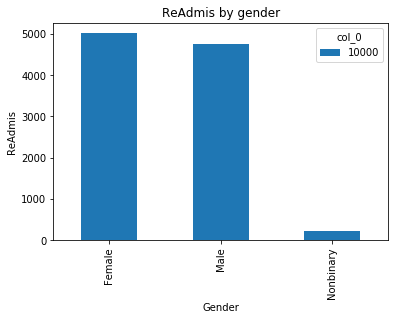

In [43]:
Total_ReAdmis = med['ReAdmis'].count()

%matplotlib inline
pd.crosstab(med['Gender'], Total_ReAdmis).plot(kind='bar')
plt.title('ReAdmis by gender')
plt.xlabel('Gender')
plt.ylabel('ReAdmis')
plt.savefig('Readmission by Gender')

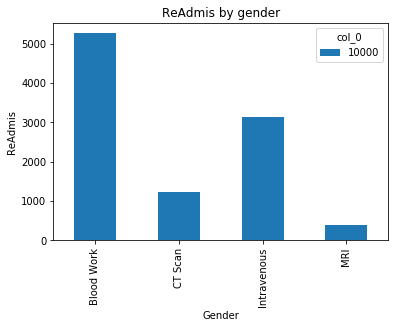

In [44]:
Total_ReAdmis = med['ReAdmis'].count()

%matplotlib inline
pd.crosstab(med['Services'], Total_ReAdmis).plot(kind='bar')
plt.title('ReAdmis by gender')
plt.xlabel('Gender')
plt.ylabel('ReAdmis')
plt.savefig('Readmission by Gender')

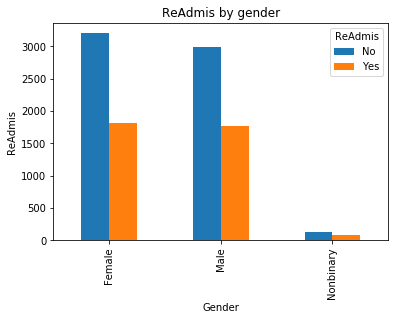

In [45]:
Total_ReAdmis = med['ReAdmis'].count()

pd.crosstab(med['Gender'], med['ReAdmis']).plot(kind='bar')
plt.title('ReAdmis by gender')
plt.xlabel('Gender')
plt.ylabel('ReAdmis')
plt.savefig('Readmission by Gender')

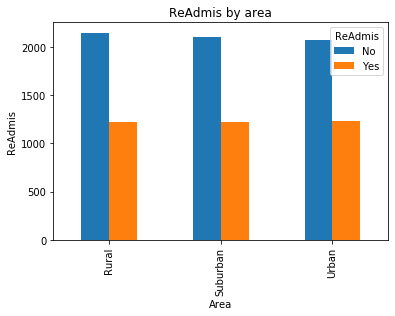

In [46]:

pd.crosstab(med['Area'], med['ReAdmis']).plot(kind='bar')
plt.title('ReAdmis by area')
plt.xlabel('Area')
plt.ylabel('ReAdmis')
plt.savefig('Readmission by Area')

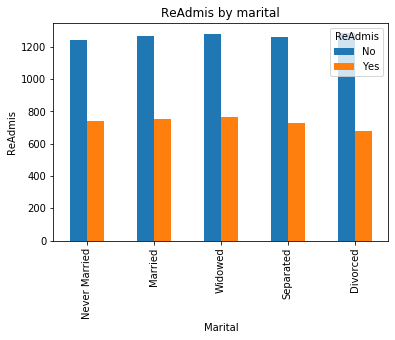

In [47]:

pd.crosstab(med['Marital'], med['ReAdmis']).plot(kind='bar')
plt.title('ReAdmis by marital')
plt.xlabel('Marital')
plt.ylabel('ReAdmis')
plt.savefig('Readmission by Marital')

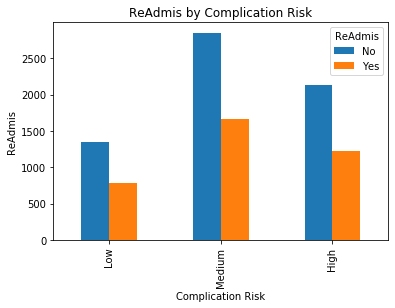

In [48]:
pd.crosstab(med['Complication_risk'], med['ReAdmis']).plot(kind='bar')
plt.title('ReAdmis by Complication Risk')
plt.xlabel('Complication Risk')
plt.ylabel('ReAdmis')
plt.savefig('Readmission by Complication Risk')

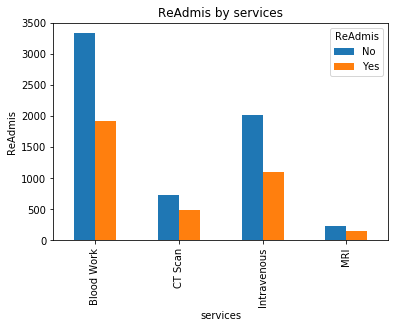

In [49]:
pd.crosstab(med['Services'], med['ReAdmis']).plot(kind='bar')
plt.title('ReAdmis by services')
plt.xlabel('services')
plt.ylabel('ReAdmis')
plt.savefig('Readmission by services')

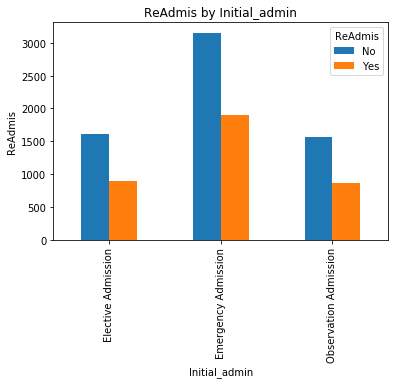

In [50]:
pd.crosstab(med['Initial_admin'], med['ReAdmis']).plot(kind='bar')
plt.title('ReAdmis by Initial_admin')
plt.xlabel('Initial_admin')
plt.ylabel('ReAdmis')
plt.savefig('Readmission by Initial_admin')

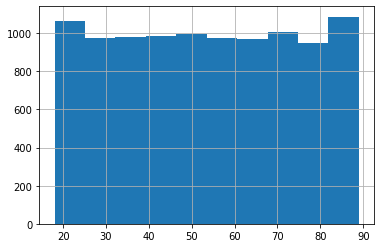

In [51]:
med['Age'].hist()

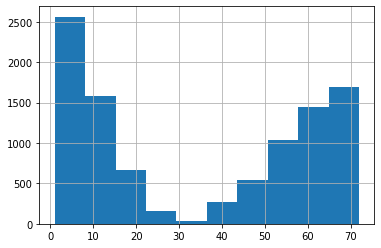

In [52]:
med['Initial_days'].hist()

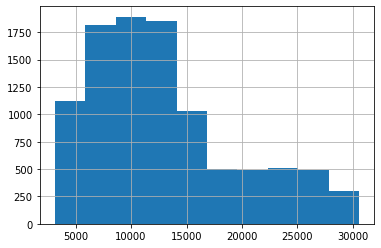

In [53]:
med['Additional_charges'].hist()

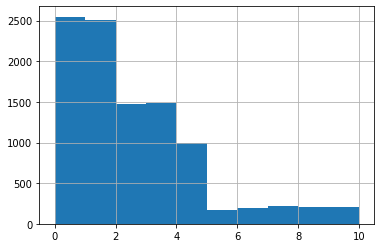

In [54]:
med['Children'].hist()

In [55]:
#create population size variable and target counts

population_size = len(med1)
print(population_size)

targets_count = sum(med1['readmis_cat'])
print(targets_count)


#print target incidence
print(targets_count/population_size)

10000
3669
0.3669


In [56]:
med['courteousstaff']

0       3
1       3
2       3
3       5
4       4
       ..
9995    4
9996    4
9997    3
9998    4
9999    4
Name: courteousstaff, Length: 10000, dtype: int64

In [57]:
# Count and print the number of readmissions.
print(sum(med1['readmis_cat'] == 1))
# Count and print the number of not readmitted.
print(sum(med1['readmis_cat'] == 0))


3669
6331


In [58]:
predictor_summaryStats = med1[['TotalCharge','Initial_days','Additional_charges','city_cat','state_cat','area_cat','job_cat'
               ,'Children','Age','Income','marital_cat','gender_cat','Doc_visits','initialadmin_cat',
                'highblood_cat','stroke_cat','complicationrisk_cat','overweight_cat','arthritis_cat',
                'diabetes_cat','hyperlipidemia_cat','backpain_cat','anxiety_cat','allergicrhinitis_cat',
                'refluxesophagitis_cat','asthma_cat','services_cat','timely_admission','timely_treatment',
                'timely_visits','reliability','options','hrsoftx','courteousstaff','evidenceactivelistening']]

predictor_summaryStats.describe()

,TotalCharge,Initial_days,Additional_charges,city_cat,state_cat,area_cat,job_cat,Children,Age,Income,marital_cat,gender_cat,Doc_visits,initialadmin_cat,highblood_cat,stroke_cat,complicationrisk_cat,overweight_cat,arthritis_cat,diabetes_cat,hyperlipidemia_cat,backpain_cat,anxiety_cat,allergicrhinitis_cat,refluxesophagitis_cat,asthma_cat,services_cat,timely_admission,timely_treatment,timely_visits,reliability,options,hrsoftx,courteousstaff,evidenceactivelistening
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5312.172769,34.455299,12934.528587,3015.819500,25.772100,0.993400,319.785200,2.097200,53.511700,40490.495160,1.991800,0.519600,5.012200,0.993200,0.409000,0.199300,1.123300,0.709400,0.357400,0.27380,0.337200,0.411400,0.321500,0.394100,0.413500,0.28930,0.862500,3.518800,3.506700,3.511100,3.515100,3.496900,3.522500,3.494000,3.509700
std,2180.393838,26.309341,6542.601544,1760.712692,14.615777,0.816837,185.114069,2.163659,20.638538,28521.153293,1.406816,0.540782,1.045734,0.702854,0.491674,0.399494,0.730172,0.454062,0.479258,0.44593,0.472777,0.492112,0.467076,0.488681,0.492486,0.45346,0.986251,1.031966,1.034825,1.032755,1.036282,1.030192,1.032376,1.021405,1.042312
min,1938.312067,1.001981,3125.703000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,154.080000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3179.374015,7.896215,7986.487755,1484.750000,14.000000,0.000000,160.000000,0.000000,36.000000,19598.775000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,5213.952000,35.836244,11573.977735,3015.500000,25.000000,1.000000,322.000000,1.000000,53.000000,33768.420000,2.000000,0.000000,5.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,3.000000,3.000000
75%,7459.699750,61.161020,15626.490000,4558.000000,38.000000,2.000000,480.000000,3.000000,71.000000,54296.402500,3.000000,1.000000,6.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,9180.728000,71.981490,30566.070000,6071.000000,51.000000,2.000000,638.000000,10.000000,89.000000,207249.100000,4.000000,2.000000,9.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,3.000000,8.000000,7.000000,8.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [59]:
response_summaryStats = med1['readmis_cat']
response_summaryStats.describe()

count    10000.000000
mean         0.366900
std          0.481983
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: readmis_cat, dtype: float64

# Discretization of continuous variable for standard probability distribution

In [60]:
variable = 'TotalCharge'
number_bins = 3
med1['disc_max_totalCharge'] = pd.qcut(med1[variable],number_bins)
med1.groupby('disc_max_totalCharge').size()

disc_max_totalCharge
(1938.311, 3454.35]     3334
(3454.35, 7069.663]     3333
(7069.663, 9180.728]    3333
dtype: int64

In [61]:
variable = 'Income'
number_bins = 3
med1['disc_max_income'] = pd.qcut(med1[variable],number_bins)
med1.groupby('disc_max_income').size()

disc_max_income
(154.079, 24184.77]     3334
(24184.77, 46310.49]    3333
(46310.49, 207249.1]    3333
dtype: int64

In [62]:
variables_model = ['TotalCharge','Initial_days','Additional_charges','city_cat','state_cat','area_cat','job_cat',
                   'Children','Age','Income','marital_cat','gender_cat','Doc_visits','initialadmin_cat',
                   'highblood_cat','stroke_cat','complicationrisk_cat','overweight_cat','arthritis_cat',
                   'diabetes_cat','hyperlipidemia_cat','backpain_cat','anxiety_cat','allergicrhinitis_cat',
                    'refluxesophagitis_cat','asthma_cat','services_cat','timely_admission','timely_treatment',
                    'timely_visits','reliability','options','hrsoftx','courteousstaff','evidenceactivelistening']
def check_discretize(med1, variable, threshold):
    return(len(med1.groupby(variable))>threshold)
check_discretize(med1, 'Income', 5)

True

In [63]:
variable = 'Additional_charges'
number_bins = 3
med1['disc_max_additionalCharges'] = pd.qcut(med1[variable],number_bins)
med1.groupby('disc_max_additionalCharges').size()

disc_max_additionalCharges
(3125.7019999999998, 9196.25]    3334
(9196.25, 14072.27]              3333
(14072.27, 30566.07]             3333
dtype: int64

In [64]:
check_discretize(med1, 'Additional_charges', 5)

True

In [65]:
variables_model = ['TotalCharge','Initial_days','Additional_charges','city_cat','state_cat','area_cat','job_cat',
                   'Children','Age','Income','marital_cat','gender_cat','Doc_visits','initialadmin_cat',
                   'highblood_cat','stroke_cat','complicationrisk_cat','overweight_cat','arthritis_cat',
                   'diabetes_cat','hyperlipidemia_cat','backpain_cat','anxiety_cat','allergicrhinitis_cat',
                    'refluxesophagitis_cat','asthma_cat','services_cat','timely_admission','timely_treatment',
                    'timely_visits','reliability','options','hrsoftx','courteousstaff','evidenceactivelistening']
def check_discretize(med1, variable, threshold):
    return(len(med1.groupby(variable))>threshold)
threshold = 5
number_bins = 5

for variable in variables_model:
    if check_discretize(med1, variable, threshold):
        new_variable = 'disc' + variable
        #to prevent error from not having unique values, add duplicates='drop' to remove duplicates
        med1[new_variable] = pd.qcut(med1[variable], number_bins, duplicates='drop')
        
print(check_discretize(med1, variable, threshold))

True


# Define the training and testing dataset

In [67]:
#separate explanatory variables from response variable

X_data = med1[['TotalCharge','Initial_days','Additional_charges','city_cat','state_cat','area_cat','job_cat'
               ,'Children','Age','Income','marital_cat','gender_cat','Doc_visits','initialadmin_cat',
                'highblood_cat','stroke_cat','complicationrisk_cat','overweight_cat','arthritis_cat',
                'diabetes_cat','hyperlipidemia_cat','backpain_cat','anxiety_cat','allergicrhinitis_cat',
                'refluxesophagitis_cat','asthma_cat','services_cat','timely_admission','timely_treatment',
                'timely_visits','reliability','options','hrsoftx','courteousstaff','evidenceactivelistening']]
#print(X_data.head())
y_data = med1['readmis_cat']
#print(y_data.head())

In [68]:
#Split dataset into training data and test data

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.3)


# Fit the Original model, get coefficients, and assign the intercept

In [69]:
# Construct a logistic regression model that predicts the target using x_train
predictors = X_train
X = predictors
y = y_train

#Perform Multivariate logistic regression

logreg = linear_model.LogisticRegression()

orig_model = logreg.fit(X_train, y_train)

# Assign the coefficients to a list coef
coef = orig_model.coef_
for p,c in zip(predictors,list(coef[0])):
    print(p + '\t' + str(c))
    
# Assign the intercept to the variable intercept
intercept = orig_model.intercept_
print(intercept)

TotalCharge	-0.0033033177806679045
Initial_days	0.531143513459106
Additional_charges	6.474336741750514e-05
city_cat	-0.00019504470223141637
state_cat	-0.017823351772494042
area_cat	-0.01790791140745656
job_cat	-0.001544296385852304
Children	-0.032946411844793154
Age	-0.03425087099925977
Income	-9.148435392248321e-06
marital_cat	-0.034711613175520385
gender_cat	-0.008310615286398251
Doc_visits	-0.08370269852510959
initialadmin_cat	-0.01659831674466636
highblood_cat	-0.004678685921589691
stroke_cat	-0.003346355355493997
complicationrisk_cat	-0.022359553106974236
overweight_cat	-0.012118101650546073
arthritis_cat	-0.007558707336316418
diabetes_cat	-0.005869383758123115
hyperlipidemia_cat	-0.0051390772041118755
backpain_cat	-0.006564021348296392
anxiety_cat	-0.005550566106897238
allergicrhinitis_cat	-0.008123946019523223
refluxesophagitis_cat	-0.007817947333976965
asthma_cat	-0.004259114260000288
services_cat	-0.014220027444295465
timely_admission	-0.05840822340053295
timely_treatment	-0.0

/Users/jeannine/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [70]:
y_pred = logreg.predict(X_test)
y_pred

array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

# Cross Validation of test train dataset

In [71]:
#import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score

#Evaluate the list of MSE ontained by 10 fold CV
#Set n_jobs to -1 in order to exploit all CPU cores in computation

MSE_CV = -cross_val_score(orig_model, X_train, y_train, cv=10,
                         scoring='neg_mean_squared_error',
                         n_jobs=-1)

#predict the labels of training set
y_predict_train = orig_model.predict(X_train)
y_predict_test = orig_model.predict(X_test)

#MSE
#CV MSE
print('CV MSE: {:.2f}'.format(MSE_CV.mean()))

#training set mse
print('Train MSE: {:.2f}'.format(MSE(y_train, y_predict_train)))

#Test set MSE - if training set error is smaller than 
#the CV-error, we can deduce that dt overfits the training set and 
#that it suffers from high variance. 
print('Test MSE: {:.2f}'.format(MSE(y_test, y_predict_test)))

CV MSE: 0.07
Train MSE: 0.07
Test MSE: 0.07


# Evaluate Original model

In [72]:
# import the metrics class
from sklearn import metrics
cf_matrix = metrics.confusion_matrix(y_test, y_pred)
cf_matrix

array([[1794,  140],
       [  63, 1003]])

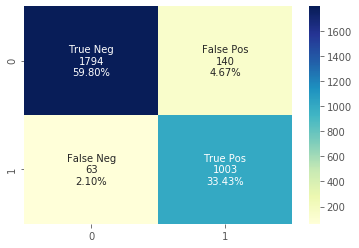

In [73]:
#Visualization libraries:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# remove future and deprecated warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='YlGnBu')

In [74]:
from sklearn.metrics import classification_report

#Generate the classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1934
           1       0.88      0.94      0.91      1066

    accuracy                           0.93      3000
   macro avg       0.92      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



In [75]:
#Confusion Matrix Evaluation Metrics

#proportion of correct predictions
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#when a model makes a prediction, how often it is correct.
print("Precision:",metrics.precision_score(y_test, y_pred))

#the ability for the model to identify the probability of readmission
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9323333333333333
Precision: 0.8775153105861767
Recall: 0.9409005628517824


In [76]:
# MSE

mse_orig_model = MSE(y_train, y_predict_train)

#RMSE
#compute test-set RMSE
rmse_orig_model = mse_orig_model**(1/2)
rmse_orig_model

0.2629502940535666

# Original model coefficients visualized 

In [77]:
importances = pd.DataFrame(data={
    'Attribute':X_train.columns,
    'Importance':orig_model.coef_[0]
})

importances = importances.sort_values(by='Importance', ascending=False)

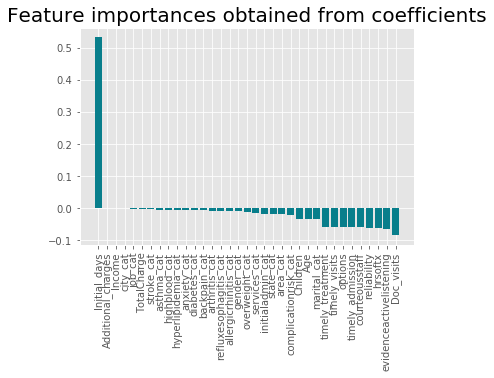

In [78]:
#Visualize coefficients
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

# Stats Model pvalue feature selection

In [79]:
X_columns = ['TotalCharge','Initial_days','Additional_charges','city_cat','state_cat','area_cat','job_cat'
               ,'Children','Age','Income','marital_cat','gender_cat','Doc_visits','initialadmin_cat',
                'highblood_cat','stroke_cat','complicationrisk_cat','overweight_cat','arthritis_cat',
                'diabetes_cat','hyperlipidemia_cat','backpain_cat','anxiety_cat','allergicrhinitis_cat',
                'refluxesophagitis_cat','asthma_cat','services_cat','timely_admission','timely_treatment',
                'timely_visits','reliability','options','hrsoftx','courteousstaff','evidenceactivelistening']

In [80]:
# importing libraries
import statsmodels.api as sm

import statsmodels.api as sm
def get_stats():
    X_1 = med1[X_columns]
    results = sm.Logit(y_data, X_1).fit()
    print(results.summary())
    
    #log_reg = sm.Logit(ytrain, Xtrain).fit()
    
get_stats()

Optimization terminated successfully.
         Current function value: 0.112305
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:            readmis_cat   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9965
Method:                           MLE   Df Model:                           34
Date:                Mon, 17 Jan 2022   Pseudo R-squ.:                  0.8291
Time:                        15:58:56   Log-Likelihood:                -1123.0
converged:                       True   LL-Null:                       -6572.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
TotalCharge                -0.0023      0.000    -12.390      0.000      -0.003  

In [81]:
X_columns.remove('Children')
get_stats()

Optimization terminated successfully.
         Current function value: 0.112319
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:            readmis_cat   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9966
Method:                           MLE   Df Model:                           33
Date:                Mon, 17 Jan 2022   Pseudo R-squ.:                  0.8291
Time:                        15:59:31   Log-Likelihood:                -1123.2
converged:                       True   LL-Null:                       -6572.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
TotalCharge                -0.0023      0.000    -12.431      0.000      -0.003  

In [82]:
# Final columns to remove

X_columns.remove('gender_cat')
X_columns.remove('stroke_cat')
X_columns.remove('timely_treatment')
X_columns.remove('diabetes_cat')
X_columns.remove('backpain_cat')
X_columns.remove('hyperlipidemia_cat')
X_columns.remove('allergicrhinitis_cat')
X_columns.remove('anxiety_cat')
X_columns.remove('services_cat')
X_columns.remove('timely_admission')
X_columns.remove('timely_visits')

get_stats()

Optimization terminated successfully.
         Current function value: 0.114034
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:            readmis_cat   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9977
Method:                           MLE   Df Model:                           22
Date:                Mon, 17 Jan 2022   Pseudo R-squ.:                  0.8265
Time:                        15:59:42   Log-Likelihood:                -1140.3
converged:                       True   LL-Null:                       -6572.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
TotalCharge                -0.0023      0.000    -13.156      0.000      -0.003  

In [83]:
#Check statsmodel using rfe columns
X_columns2 = ['Initial_days','complicationrisk_cat', 'initialadmin_cat',
                'diabetes_cat','backpain_cat','anxiety_cat',
                'refluxesophagitis_cat','evidenceactivelistening']

In [84]:
import statsmodels.api as sm
def get_stats2():
    X_rfe = med1[X_columns2]
    results = sm.Logit(y_data, X_rfe).fit()
    print(results.summary())
    
get_stats2()

Optimization terminated successfully.
         Current function value: 0.232989
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            readmis_cat   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9992
Method:                           MLE   Df Model:                            7
Date:                Mon, 17 Jan 2022   Pseudo R-squ.:                  0.6455
Time:                        16:00:04   Log-Likelihood:                -2329.9
converged:                       True   LL-Null:                       -6572.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Initial_days                0.1316      0.003     47.947      0.000       0.126   

# RFE feature selection

In [85]:
# Import your necessary dependencies
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Feature extraction
model = LogisticRegression()
rfe = RFE(model, 11)
fit = rfe.fit(X_data, y_data)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

/Users/jeannine/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/jeannine/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

Num Features: 11
Selected Features: [False  True False False False False False False False False False False
 False  True  True  True  True  True False False False False  True  True
  True  True False False False False False False False False  True]
Feature Ranking: [20  1 24 23 14 18 22 15 19 25  5  6  8  1  1  1  1  1 12 10 11 21  1  1
  1  1 16  3  9  4 13  2 17  7  1]


/Users/jeannine/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/jeannine/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [86]:
print(X_data.columns, fit.ranking_)

Index(['TotalCharge', 'Initial_days', 'Additional_charges', 'city_cat',
       'state_cat', 'area_cat', 'job_cat', 'Children', 'Age', 'Income',
       'marital_cat', 'gender_cat', 'Doc_visits', 'initialadmin_cat',
       'highblood_cat', 'stroke_cat', 'complicationrisk_cat', 'overweight_cat',
       'arthritis_cat', 'diabetes_cat', 'hyperlipidemia_cat', 'backpain_cat',
       'anxiety_cat', 'allergicrhinitis_cat', 'refluxesophagitis_cat',
       'asthma_cat', 'services_cat', 'timely_admission', 'timely_treatment',
       'timely_visits', 'reliability', 'options', 'hrsoftx', 'courteousstaff',
       'evidenceactivelistening'],
      dtype='object') [20  1 24 23 14 18 22 15 19 25  5  6  8  1  1  1  1  1 12 10 11 21  1  1
  1  1 16  3  9  4 13  2 17  7  1]


In [87]:
med_rank = pd.DataFrame(columns = ['Names', 'Rank'])
                        
med_rank['Names'] = X_data.columns
                        
med_rank['Rank'] = fit.ranking_


In [88]:
med_rank

,Names,Rank
0,TotalCharge,20
1,Initial_days,1
2,Additional_charges,24
3,city_cat,23
4,state_cat,14
5,area_cat,18
6,job_cat,22
7,Children,15
8,Age,19
9,Income,25


# Create reduced model

In [89]:
#separate explanatory variables from response variable
        
X_data2 = med1[['Initial_days','initialadmin_cat','highblood_cat',
                'stroke_cat','complicationrisk_cat','overweight_cat','anxiety_cat',
                'allergicrhinitis_cat','refluxesophagitis_cat','asthma_cat',
                'evidenceactivelistening']]
#print(X_data.head())
y_data2 = med1['readmis_cat']
#print(y_data.head())

In [90]:
#Split dataset into training data and test data

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_data2, y_data2, test_size = 0.3)

In [91]:
# Construct a logistic regression model that predicts the target using x_train
predictors = X_train2
X = predictors
y = y_train2

#Perform Multivariate logistic regression

logreg = linear_model.LogisticRegression()

reduced_model = logreg.fit(X_train2, y_train2)

# Assign the coefficients to a list coef
coef = reduced_model.coef_
for p,c in zip(predictors,list(coef[0])):
    print(p + '\t' + str(c))
    
# Assign the intercept to the variable intercept
intercept = reduced_model.intercept_
print(intercept)

Initial_days	1.1414484681712223
initialadmin_cat	0.3363135753240055
highblood_cat	0.4961265290981765
stroke_cat	1.2853941248232088
complicationrisk_cat	0.6597521074699437
overweight_cat	-0.31873368421405374
anxiety_cat	-0.7786948542175967
allergicrhinitis_cat	-0.17155478720067585
refluxesophagitis_cat	-0.20352159019302019
asthma_cat	-1.0298233314125425
evidenceactivelistening	-0.18547801355268181
[-61.86652064]


/Users/jeannine/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [92]:
y_pred2 = logreg.predict(X_test2)
y_pred2

array([0, 1, 0, ..., 0, 0, 1], dtype=int8)

In [93]:
#Coefficients by importance

importances = pd.DataFrame(data={
    'Attribute':X_train2.columns,
    'Importance':reduced_model.coef_[0]
})

importances = importances.sort_values(by='Importance', ascending=False)

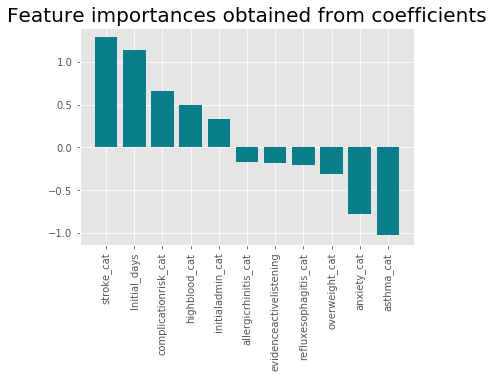

In [94]:
#Visualize coefficients
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

# Evaluate reduced model

In [95]:
# import the metrics class
from sklearn import metrics
cf_matrix2 = metrics.confusion_matrix(y_test2, y_pred2)
cf_matrix2

array([[1838,   41],
       [  25, 1096]])

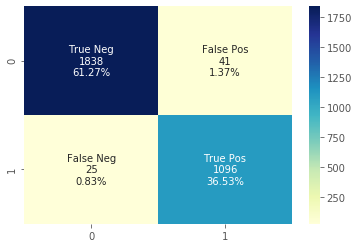

In [96]:
#Visualization libraries:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# remove future and deprecated warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix2.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix2.flatten()/np.sum(cf_matrix2)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix2, annot=labels, fmt='', cmap='YlGnBu')

In [98]:
from sklearn.metrics import classification_report

#Generate the classification report
class_report2 = classification_report(y_test2, y_pred2)
print(class_report2)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1879
           1       0.96      0.98      0.97      1121

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [100]:
#Confusion Matrix Evaluation Metrics

#proportion of correct predictions
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred2))

#when a model makes a prediction, how often it is correct.
print("Precision:",metrics.precision_score(y_test2, y_pred2))

#the ability for the model to identify the probability of readmission
print("Recall:",metrics.recall_score(y_test2, y_pred2))

Accuracy: 0.978
Precision: 0.9639401934916447
Recall: 0.9776984834968778


In [101]:
#Evaluate the list of MSE ontained by 10 fold CV
#Set n_jobs to -1 in order to exploit all CPU cores in computation

MSE_CV2 = -cross_val_score(reduced_model, X_train2, y_train2, cv=10,
                         scoring='neg_mean_squared_error',
                         n_jobs=-1)

#predict the labels of training set
y_predict_train2 = reduced_model.predict(X_train2)
y_predict_test2 = reduced_model.predict(X_test2)

#MSE
#CV MSE
print('CV MSE: {:.2f}'.format(MSE_CV2.mean()))

#training set mse
print('Train MSE: {:.2f}'.format(MSE(y_train2, y_predict_train2)))

#Test set MSE - if training set error is smaller than 
#the CV-error, we can deduce that dt overfits the training set and 
#that it suffers from high variance. 
print('Test MSE: {:.2f}'.format(MSE(y_test2, y_predict_test2)))

CV MSE: 0.02
Train MSE: 0.02
Test MSE: 0.02


In [102]:
#MSE
#compute test-set mse
mse_reduced_model = MSE(y_test2, y_pred2)
mse_reduced_model

0.022

In [104]:
#RMSE
#compute test-set RMSE
rmse_reduced_model = mse_reduced_model**(1/2)
rmse_reduced_model

0.14832396974191325

# Feature Importance - RandomForest

In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


rf_X = pd.DataFrame(X_data, columns=['TotalCharge','Initial_days','Additional_charges','city_cat','state_cat','area_cat','job_cat',
                   'Children','Age','Income','marital_cat','gender_cat','Doc_visits','initialadmin_cat',
                   'highblood_cat','stroke_cat','complicationrisk_cat','overweight_cat','arthritis_cat',
                   'diabetes_cat','hyperlipidemia_cat','backpain_cat','anxiety_cat','allergicrhinitis_cat',
                    'refluxesophagitis_cat','asthma_cat','services_cat','timely_admission','timely_treatment',
                    'timely_visits','reliability','options','hrsoftx','courteousstaff','evidenceactivelistening'])
rf_y = med1.readmis_cat


In [106]:
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(rf_X, rf_y, test_size=0.3, random_state=42)

In [107]:
rf = RandomForestRegressor(n_estimators=150)
rf.fit(rf_X_train, rf_y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Text(0.5, 0, 'Feature Importance')

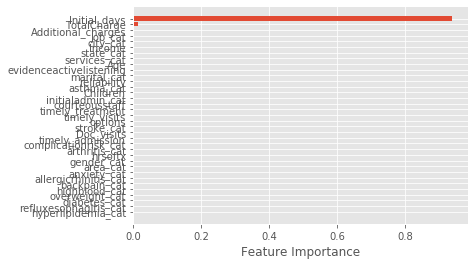

In [108]:
sort = rf.feature_importances_.argsort()
plt.barh(rf_X.columns[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")

In [109]:
rf_X2 = pd.DataFrame(X_data, columns=['Initial_days','highblood_cat','complicationrisk_cat',
                'diabetes_cat','hyperlipidemia_cat','backpain_cat','anxiety_cat',
                'refluxesophagitis_cat','evidenceactivelistening'])
rf_y2 = med1.readmis_cat


In [110]:
rf_X_train2, rf_X_test2, rf_y_train2, rf_y_test2 = train_test_split(rf_X2, rf_y2, test_size=0.3, random_state=42)

In [111]:
rf2 = RandomForestRegressor(n_estimators=150)
rf2.fit(rf_X_train2, rf_y_train2)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Text(0.5, 0, 'Feature Importance')

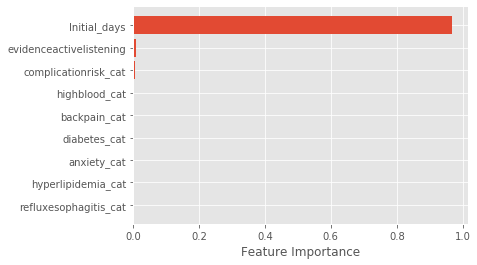

In [112]:
sort = rf2.feature_importances_.argsort()
plt.barh(rf_X2.columns[sort], rf2.feature_importances_[sort])
plt.xlabel("Feature Importance")

In [113]:
rf_X_data3 = med1[['Initial_days','initialadmin_cat','highblood_cat',
                'stroke_cat','complicationrisk_cat','overweight_cat','anxiety_cat',
                'allergicrhinitis_cat','refluxesophagitis_cat','asthma_cat',
                   'evidenceactivelistening']]
rf_y_data3 = med1.readmis_cat

In [114]:
rf_X3 = pd.DataFrame(rf_X_data3, columns=['Initial_days','initialadmin_cat','highblood_cat',
                'stroke_cat','complicationrisk_cat','overweight_cat','anxiety_cat',
                'allergicrhinitis_cat','refluxesophagitis_cat','asthma_cat',
                   'evidenceactivelistening'])
rf_y3 = med1.readmis_cat

In [115]:
rf_X_train3, rf_X_test3, rf_y_train3, rf_y_test3 = train_test_split(rf_X_data3, rf_y_data3, test_size=0.3)

In [116]:
rf3 = RandomForestRegressor(n_estimators=150)
rf3.fit(rf_X_train3, rf_y_train3)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Text(0.5, 0, 'Feature Importance')

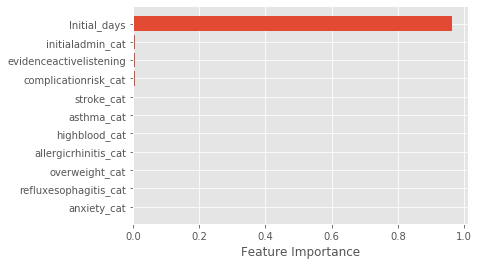

In [117]:
sort = rf3.feature_importances_.argsort()
plt.barh(rf_X3.columns[sort], rf3.feature_importances_[sort])
plt.xlabel("Feature Importance")

# Using AUC to compare model performance

In [118]:
#AUC --> measure used to quantify the performance of predictive models
# Perfect models have an AUC of 1, whereas random models have an AUC of about 0.5.
# Create appropriate dataframes
variables_1 = med1[['TotalCharge','Initial_days','Additional_charges','city_cat','state_cat','area_cat','job_cat'
               ,'Children','Age','Income','marital_cat','gender_cat','Doc_visits','initialadmin_cat',
                'highblood_cat','stroke_cat','complicationrisk_cat','overweight_cat','arthritis_cat',
                'diabetes_cat','hyperlipidemia_cat','backpain_cat','anxiety_cat','allergicrhinitis_cat',
                'refluxesophagitis_cat','asthma_cat','services_cat','timely_admission','timely_treatment',
                'timely_visits','reliability','options','hrsoftx','courteousstaff','evidenceactivelistening']]

variables_2 = med1[['Initial_days','highblood_cat','arthritis_cat','complicationrisk_cat',
                'diabetes_cat','hyperlipidemia_cat','backpain_cat','anxiety_cat',
                'refluxesophagitis_cat','evidenceactivelistening']]


variables_3 = med1[['Initial_days','initialadmin_cat','highblood_cat',
                'stroke_cat','complicationrisk_cat','overweight_cat','anxiety_cat',
                'allergicrhinitis_cat','refluxesophagitis_cat','asthma_cat', 'evidenceactivelistening']]

variables_4 = med1[['Initial_days','initialadmin_cat','complicationrisk_cat','evidenceactivelistening']]

target = med1['readmis_cat']

X_1 = variables_1
X_2 = variables_2
X_3 = variables_3
X_4 = variables_4

y = target

# Create the logistic regression model
logreg = linear_model.LogisticRegression()

# Make predictions using the first set of variables and assign the AUC to auc_1
logreg.fit(X_1, y)
predictions_1 = logreg.predict_proba(X_1)[:,1]
auc_1 = roc_auc_score(y, predictions_1)

# Make predictions using the second set of variables and assign the AUC to auc_2
logreg.fit(X_2, y)
predictions_2 = logreg.predict_proba(X_2)[:,1]
auc_2 = roc_auc_score(y, predictions_2)


# Make predictions using the second set of variables and assign the AUC to auc_3
logreg.fit(X_3, y)
predictions_3 = logreg.predict_proba(X_3)[:,1]
auc_3 = roc_auc_score(y, predictions_3)

# Make predictions using the second set of variables and assign the AUC to auc_4
logreg.fit(X_4, y)
predictions_4 = logreg.predict_proba(X_4)[:,1]
auc_4 = roc_auc_score(y, predictions_4)


# Print auc_1 and auc_2
print(round(auc_1,2))
print(round(auc_2,2))
print(round(auc_3,2))
print(round(auc_4,2))

0.98
1.0
1.0
1.0


/Users/jeannine/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/jeannine/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

In [ ]:
# transformed_data = med1.to_excel(''/Users/jeannine/OneDrive/Documents/WGU/D208 - predictive modeling/D208 - Predictive Modeling - Assignment 2 - Transformed Data.xlsx', index=False)

# Attempt at stepwise function

In [ ]:
# Create auc function
def auc(variables, target, med1):
    X = med1[['TotalCharge','Initial_days','Additional_charges','city_cat','state_cat','area_cat','job_cat'
               ,'Children','Age','Income','marital_cat','gender_cat','Doc_visits','initialadmin_cat',
                'highblood_cat','stroke_cat','complicationrisk_cat','overweight_cat','arthritis_cat',
                'diabetes_cat','hyperlipidemia_cat','backpain_cat','anxiety_cat','allergicrhinitis_cat',
                'refluxesophagitis_cat','asthma_cat','services_cat','timely_admission','timely_treatment',
                'timely_visits','reliability','options','hrsoftx','courteousstaff','evidenceactivelistening']]
    y = med1['readmis_cat']
    
    logreg = linear_model.LogisticRegression(max_iter=35)
    
    logreg.fit(X,y)
    
    predictions = logreg.predict_proba(X)[:,1]
    auc = roc_auc_score(y, predictions)
    return(auc)

In [ ]:
#'Initial_days','','highblood_cat','stroke_cat','','overweight_cat','anxiety_cat','allergicrhinitis_cat','refluxesophagitis_cat','asthma_cat'

auc = auc(['TotalCharge','Initial_days','Additional_charges','city_cat','state_cat','area_cat','job_cat'
               ,'Children','Age','Income','marital_cat','gender_cat','Doc_visits','initialadmin_cat',
                'highblood_cat','stroke_cat','complicationrisk_cat','overweight_cat','arthritis_cat',
                'diabetes_cat','hyperlipidemia_cat','backpain_cat','anxiety_cat','allergicrhinitis_cat',
                'refluxesophagitis_cat','asthma_cat','services_cat','timely_admission','timely_treatment',
                'timely_visits','reliability','options','hrsoftx','courteousstaff','evidenceactivelistening'], ['readmis_cat'], med1)
print(round(auc,2))

In [ ]:
# Create auc function
def auc(variables, target, med1):
    X = med1[['Initial_days','highblood_cat','complicationrisk_cat',
                'diabetes_cat','hyperlipidemia_cat','backpain_cat','anxiety_cat',
                'refluxesophagitis_cat','evidenceactivelistening']]
    y = med1['readmis_cat']
    
    logreg = linear_model.LogisticRegression(max_iter=35)
    
    logreg.fit(X,y)
    
    predictions = logreg.predict_proba(X)[:,1]
    auc = roc_auc_score(y, predictions)
    return(auc)

In [ ]:
auc_current = auc(['Initial_days','highblood_cat','complicationrisk_cat',
                'diabetes_cat','hyperlipidemia_cat','backpain_cat','anxiety_cat',
                'refluxesophagitis_cat','evidenceactivelistening'], ['readmis_cat'], med1)
print(round(auc_current,2))

In [ ]:
# Create auc function
def auc(variables, target, med1):
    X = med1[['TotalCharge','Initial_days']]
    y = med1['readmis_cat']
    
    logreg = linear_model.LogisticRegression(max_iter=35)
    
    logreg.fit(X,y)
    
    predictions = logreg.predict_proba(X)[:,1]
    auc = roc_auc_score(y, predictions)
    return(auc)

In [ ]:
def next_best(variables, candidate_variables, target, med1):
    
    best_auc = 1
    best_variable = None
    
    for v in candidate_variables:
        auc_v = auc(variables + [v], target, med1)
        
        if auc_v >= best_auc:
            best_auc = auc_v
            best_variable = v
            
    return best_variable

In [ ]:
current_variables = ['Initial_days','TotalCharge']
candidate_variables = ['initialadmin_cat','highblood_cat',
                'stroke_cat','complicationrisk_cat','overweight_cat','anxiety_cat',
                'allergicrhinitis_cat','refluxesophagitis_cat','asthma_cat']

next_variable = next_best(current_variables, candidate_variables, target, med1)
print(next_variable,35)

In [ ]:
candidate_variables = ['TotalCharge','Initial_days','Additional_charges','city_cat','state_cat','area_cat','job_cat'
               ,'Children','Age','Income','marital_cat','gender_cat','Doc_visits','initialadmin_cat',
                'highblood_cat','stroke_cat','complicationrisk_cat','overweight_cat','arthritis_cat',
                'diabetes_cat','hyperlipidemia_cat','backpain_cat','anxiety_cat','allergicrhinitis_cat',
                'refluxesophagitis_cat','asthma_cat','services_cat','timely_admission','timely_treatment',
                'timely_visits','reliability','options','hrsoftx','courteousstaff','evidenceactivelistening']

current_variables = []

number_iterations = 35
for i in range(0, number_iterations):
    next_variable = next_best(current_variables,candidate_variables, target,med1)
    current_variables = current_variables + [next_variable]
    #candidate_variables.remove(next_variable)
    #print("Variable added in step " + str(i+1)  + " is " + next_variable + ".")
print(current_variables)

In [ ]:
## creating a linear model and prediction
X = med1[X_columns]
model_1 = linear_model.LogisticRegression()
model_1.fit(X, y)
#sg_data = pd.read_csv('testing.csv')
#x_test = sg_data[x_columns]
y_pred = model_1.predict(X)
print("Prediction is ", y_pred)

In [ ]:
# Find the candidate variables
# Make predictions using the second set of variables and assign the AUC to auc_2
#logreg.fit(X_2, y)
#predictions_2 = logreg.predict_proba(X_2)[:,1]
#auc_2 = roc_auc_score(y, predictions_2)

candidate_variables = ['TotalCharge','Initial_days','Additional_charges','city_cat','state_cat','area_cat','job_cat'
               ,'Children','Age','Income','marital_cat','gender_cat','Doc_visits','initialadmin_cat',
                'highblood_cat','stroke_cat','complicationrisk_cat','overweight_cat','arthritis_cat',
                'diabetes_cat','hyperlipidemia_cat','backpain_cat','anxiety_cat','allergicrhinitis_cat',
                'refluxesophagitis_cat','asthma_cat','services_cat','timely_admission','timely_treatment',
                'timely_visits','reliability','options','hrsoftx','courteousstaff','evidenceactivelistening']

# Initialize the current variables
current_variables = []

#target = ['readmis_cat']

 ##list(med1.columns.values)
#candidate_variables.remove(target)

max_number_variables = 50

# The forward stepwise variable selection procedure
number_iterations = min(max_number_variables, len(candidate_variables))


for i in range(0, number_iterations):
    next_variable = next_best(current_variables, candidate_variables, target , med1)
    current_variables = current_variables + [next_variable]
    #candidate_variables.remove(next_variable)
    #print("Variable added in step " + str(i+1)  + " is " + next_variable + ".")